In [832]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from math import ceil
from scipy.stats import zscore, mstats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier, plot_importance


In [833]:
# notebook config
pd.set_option("display.max_rows", 20)

In [834]:
# load dataset
df = pd.read_csv("gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv")

In [835]:
df.shape

(11537, 14)

In [836]:
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes


In [837]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Type          11537 non-null  object
 1   Age           11537 non-null  int64 
 2   Breed1        11537 non-null  object
 3   Gender        11537 non-null  object
 4   Color1        11537 non-null  object
 5   Color2        11537 non-null  object
 6   MaturitySize  11537 non-null  object
 7   FurLength     11537 non-null  object
 8   Vaccinated    11537 non-null  object
 9   Sterilized    11537 non-null  object
 10  Health        11537 non-null  object
 11  Fee           11537 non-null  int64 
 12  PhotoAmt      11537 non-null  int64 
 13  Adopted       11537 non-null  object
dtypes: int64(3), object(11)
memory usage: 1.2+ MB


In [838]:
df.describe()

,Age,Fee,PhotoAmt
count,11537.000000,11537.000000,11537.000000
mean,11.743434,23.957268,3.610211
std,19.324221,80.024226,3.145872
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000
50%,4.000000,0.000000,3.000000
75%,12.000000,0.000000,5.000000
max,255.000000,2000.000000,30.000000


## Data Exploration

The target is Adopted. It a binary classification problem.

There 13 features.
- 3 of the features are numerical.
- 10 of the features are categorical.

There is no missing data.

At ~10k rows the data set is still relatively small.

### Categorical Features

In [839]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)
categorical_columns

['Type',
 'Breed1',
 'Gender',
 'Color1',
 'Color2',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Sterilized',
 'Health',
 'Adopted']

In [840]:
for i in df.select_dtypes(include=['object']):
    print("\n")
    print(df[i].value_counts())



Type
Dog    6601
Cat    4936
Name: count, dtype: int64


Breed1
Mixed Breed             4629
Domestic Short Hair     2605
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
                        ... 
Bedlington Terrier         1
American Bulldog           1
Rhodesian Ridgeback        1
Setter                     1
Dutch Shepherd             1
Name: count, Length: 166, dtype: int64


Gender
Female    6466
Male      5071
Name: count, dtype: int64


Color1
Black     5241
Brown     3075
Golden     789
Cream      765
White      593
Gray       575
Yellow     499
Name: count, dtype: int64


Color2
No Color    3968
White       2920
Brown       2203
Cream        788
Gray         659
Yellow       535
Golden       464
Name: count, dtype: int64


MaturitySize
Medium    8016
Small     2480
Large     1041
Name: count, dtype: int64


FurLength
Short     6676
Medium    4152
Long       709
Name: count, dtype: int64


Vaccinated
Yes         5060
No          4962
N

In [841]:
df[categorical_columns].nunique()

Type              2
Breed1          166
Gender            2
Color1            7
Color2            7
MaturitySize      3
FurLength         3
Vaccinated        3
Sterilized        3
Health            3
Adopted           2
dtype: int64

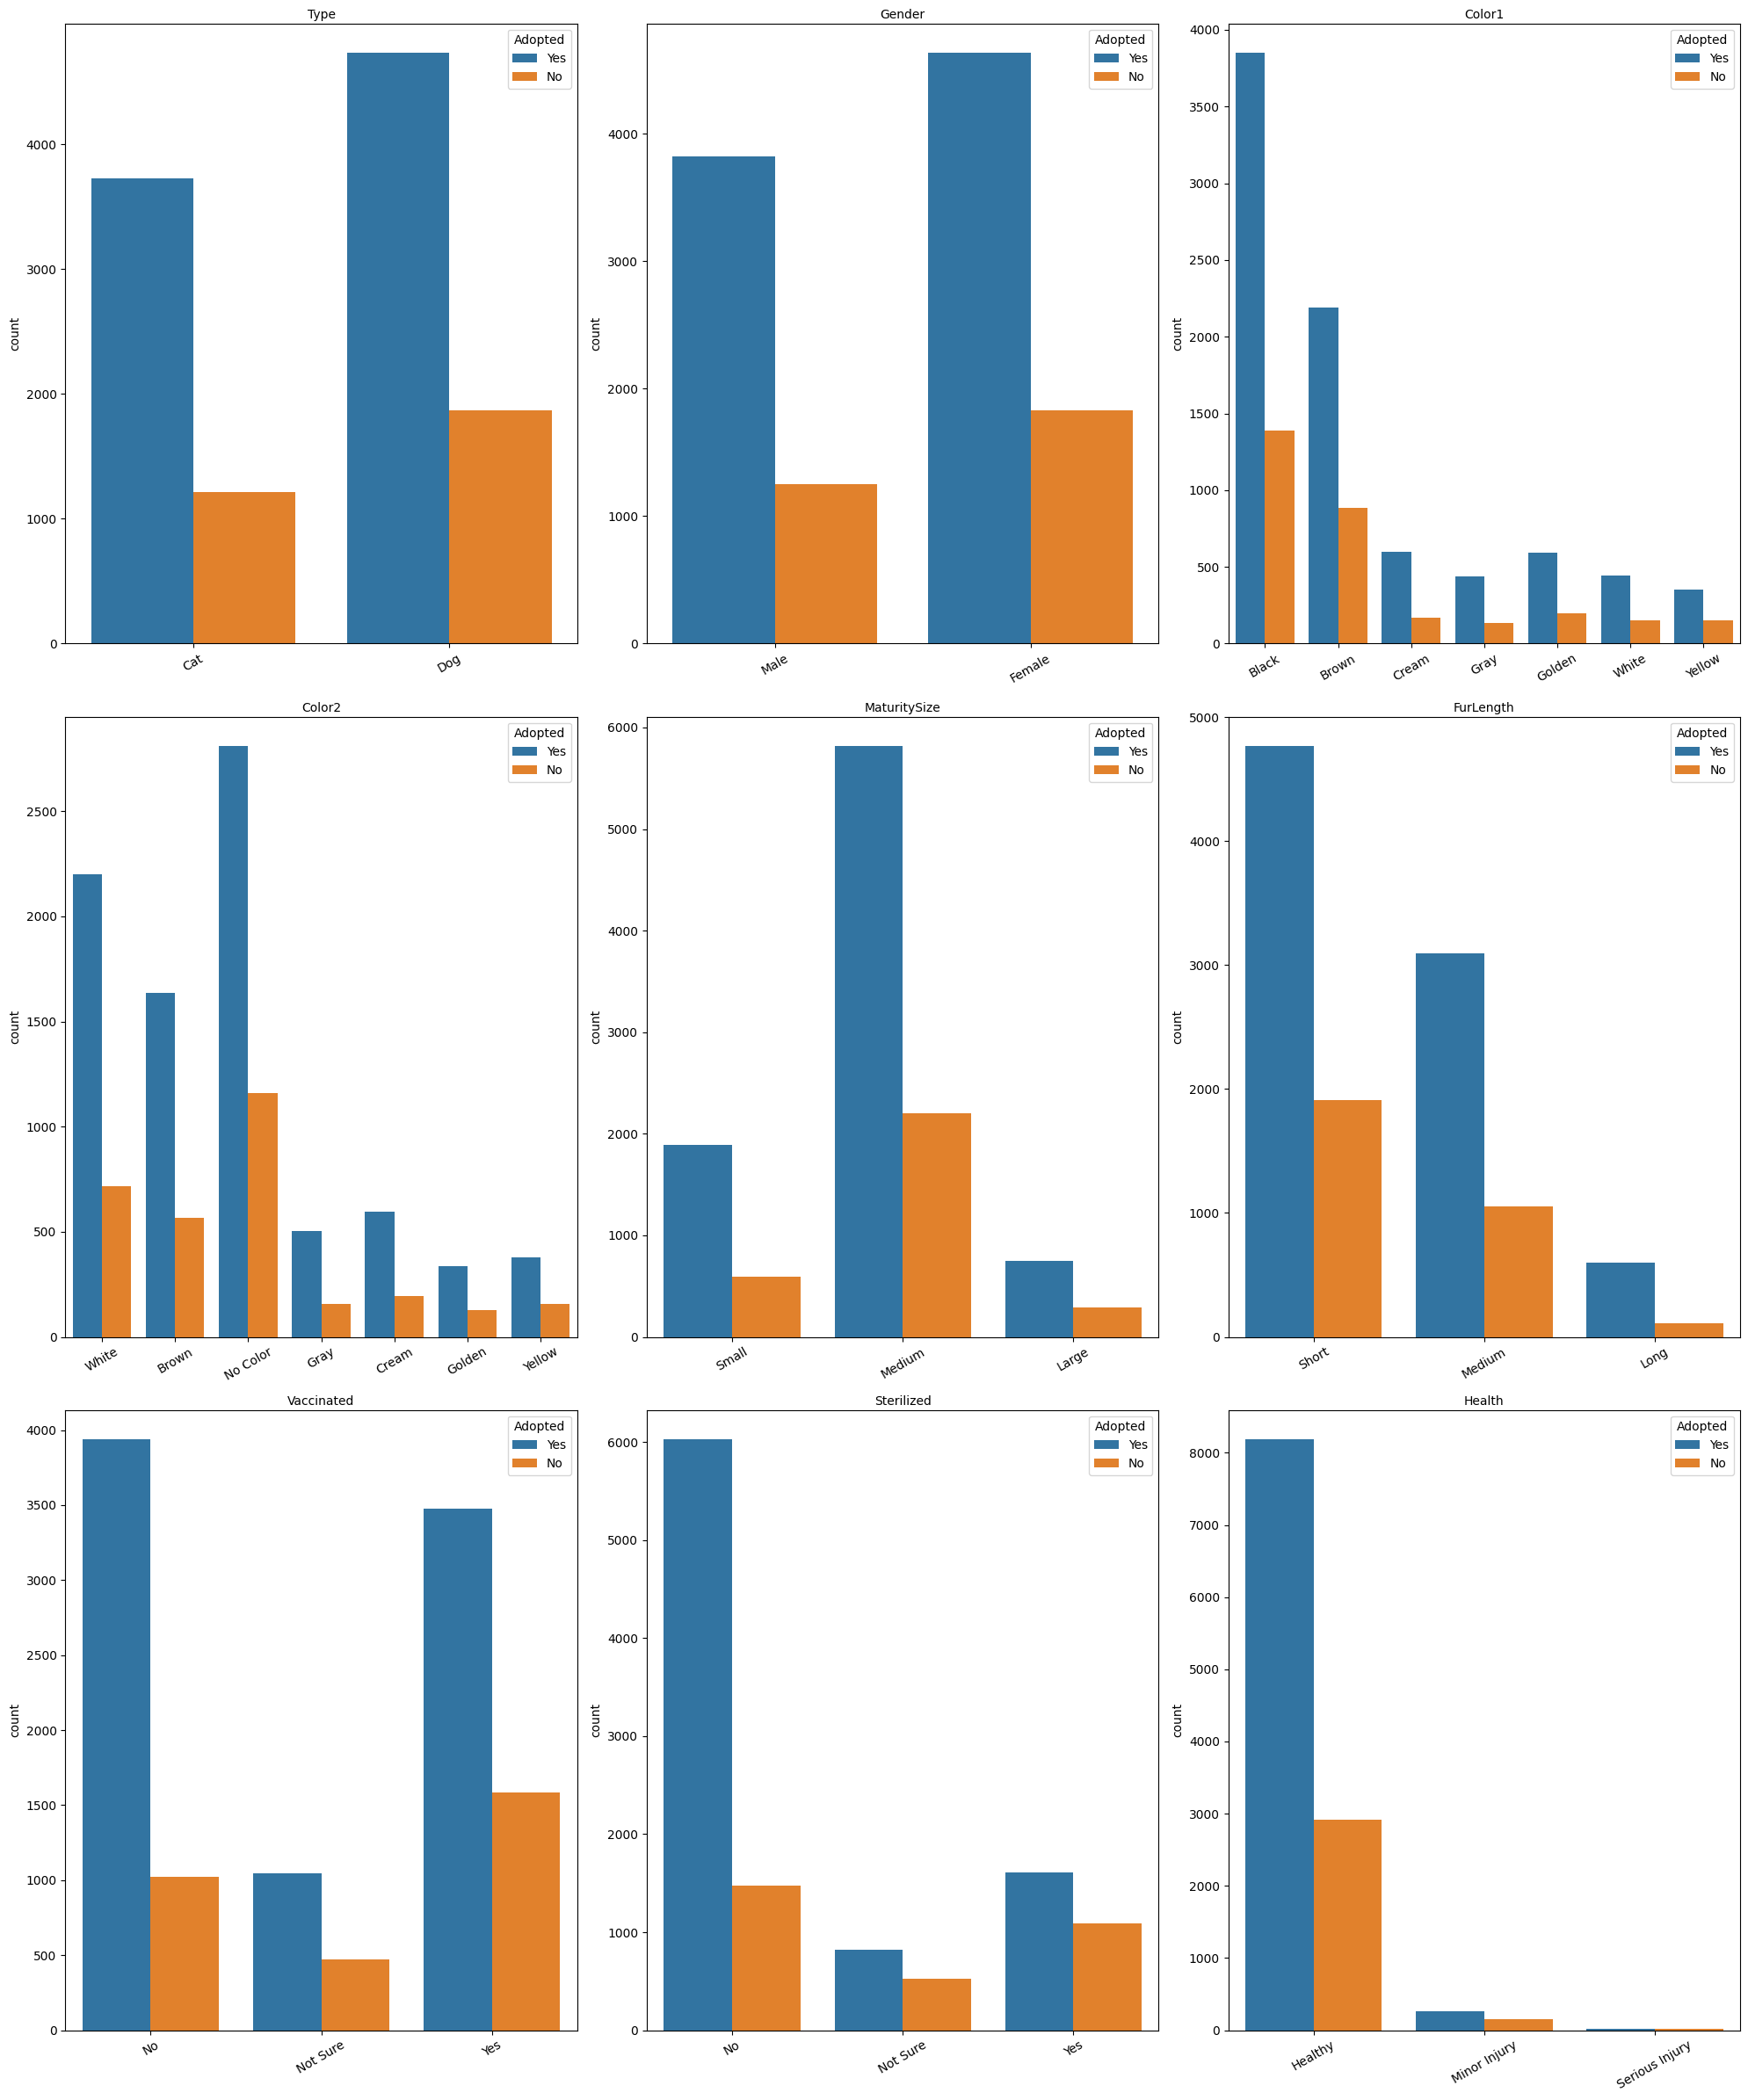

In [842]:
# visualise the distribution of each categorical feature

features_to_plot = [x for x in categorical_columns if x not in ["Breed1", "Adopted"]]

n_cols = 3
n_rows = ceil(len(features_to_plot) / n_cols)

_, axs = plt.subplots(n_rows, n_cols, figsize=(20,24))

for i, feature in enumerate(features_to_plot):

    j = i % n_cols
    k = i // n_cols

    ax = axs[k, j]
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis="x", rotation=30)

    sns.countplot(data=df, x=feature, hue=target, ax=ax)

plt.tight_layout()

In [843]:
# try and visualise Breed1 categories

# sns.countplot(x="Breed1", hue=target, data=df)
# plt.show()


In [844]:
df['Breed1'].value_counts()

Breed1
Mixed Breed             4629
Domestic Short Hair     2605
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
                        ... 
Bedlington Terrier         1
American Bulldog           1
Rhodesian Ridgeback        1
Setter                     1
Dutch Shepherd             1
Name: count, Length: 166, dtype: int64

- The most significant factors for adoption appear to be due to health statistics, Whether the pet is not steralized, not vaccinated and healthy.
- There are large number of unique categories for `Breed1`, the vast majority of pets fall under general breeds `Mixed Breed`, `Domestic Medium Hair` , `Domestic Short Hair` , and `Domestic Long Hair`


- `MaturitySize`, `FurLength` and `Health` are features that are ordinal so we should use an `OrdinalEncoder` 
- The remaining features we can encode with a `OneHotEncoder`.

### Numerical Features

In [845]:
numerical_features = list(df.select_dtypes(include=['int64']).columns)
numerical_features

['Age', 'Fee', 'PhotoAmt']

In [846]:
# Check the z score of the numerical features to determine outliers in the data

for i in df.select_dtypes(include=['int64']).columns:
    z = np.abs(zscore(df[i]))
    
    threshold = 3
    
    print(f"Percentage of rows with outliers determined by zscore with a threshold of {threshold} for {i}: {round(100*len(np.where(z > 3)[0])/df.shape[0], 2)}%")

Percentage of rows with outliers determined by zscore with a threshold of 3 for Age: 2.92%
Percentage of rows with outliers determined by zscore with a threshold of 3 for Fee: 2.53%
Percentage of rows with outliers determined by zscore with a threshold of 3 for PhotoAmt: 1.7%


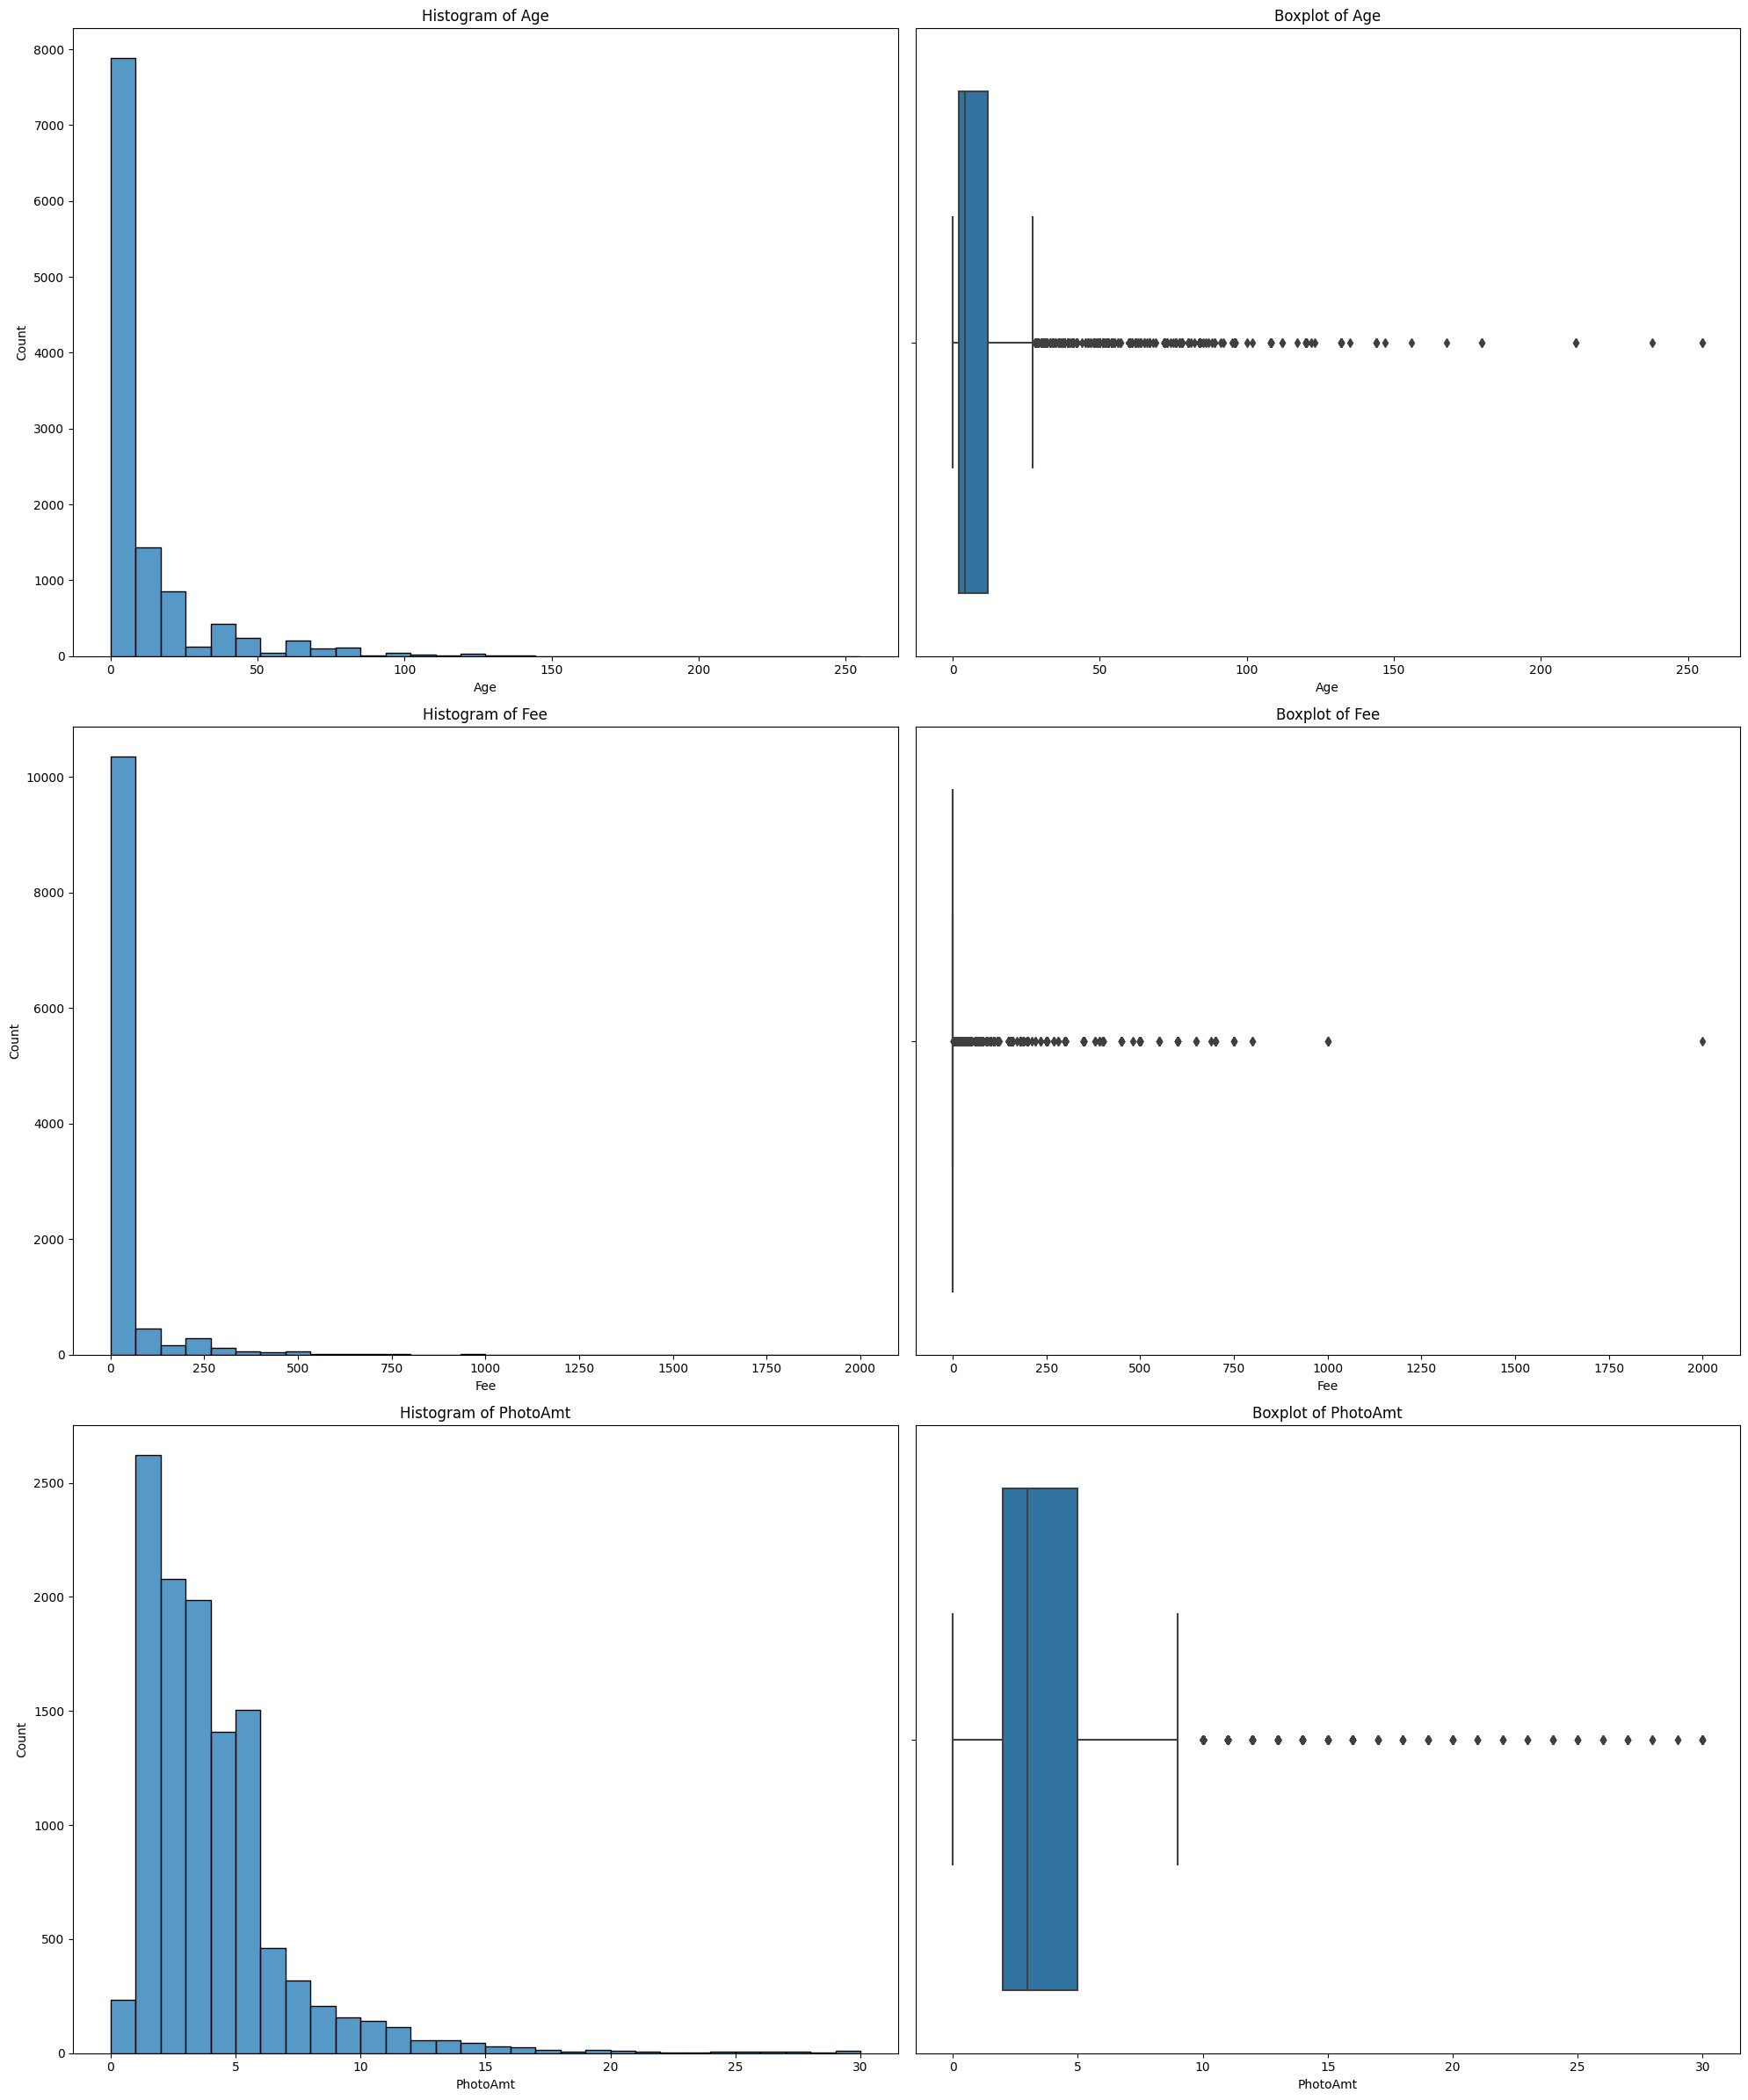

In [847]:
# Plot a histogram and a boxplot to visualise outliers

_, axs = plt.subplots(len(numerical_features), 2, figsize=(20, 24))

for i, feature in enumerate(numerical_features):

    # Plot histogram
    sns.histplot(df[feature], bins=30, ax=axs[i ,0])
    # axs[0, i].hist(df[feature], bins=30)
    axs[i, 0].set_title(f"Histogram of {feature}")

    # Plot boxplot
    sns.boxplot(x=df[feature], ax=axs[i, 1])
    axs[i, 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()


- There is significant number of outliers in each of the numerical features and in particular `Age` and `Fee`. We could use a method like winzorize to limit the extreme upper end values.
- XGBoost is fairly robust to scale and distribution, therefore scaling will not be required.

## Splitting the data

In [848]:
target = "Adopted"

In [849]:
# Gather data
y = df[target]
X = df.drop([target], axis=1)

In [850]:
# get training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [851]:
# get evaluation and test data 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [852]:
count_rows = X_train.shape[0] + X_test.shape[0] + X_val.shape[0]

print(f"Proportion of rows in X_train: {round(X_train.shape[0]/count_rows, 2)}")
print(f"Proportion of rows in X_test: {round(X_test.shape[0]/count_rows, 2)}")
print(f"Proportion of rows in X_val: {round(X_val.shape[0]/count_rows, 2)}")

Proportion of rows in X_train: 0.6
Proportion of rows in X_test: 0.2
Proportion of rows in X_val: 0.2


## Preprocessing

In [853]:
# define the categorical feature columns and the ordering of the ordinal features

categorical_features = list(X.select_dtypes(include=['object']).columns)

ordinal_features = {
    "Health": ["Healthy", "Minor Injury", "Serious Injury"],
    "FurLength": ["Short", "Medium", "Long"],
    "MaturitySize": ["Small", "Medium", "Large"],
}

ordinal_columns = list(ordinal_features.keys())

onehot_columns = [x for x in categorical_features if x not in ordinal_columns]


In [854]:
numerical_columns = list(X.select_dtypes(include=['int64']).columns)
numerical_columns

['Age', 'Fee', 'PhotoAmt']

In [855]:
# create a winsorizer transformer to limit extreme values
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None):
        return X.apply(mstats.winsorize, limits=self.limits)

    def get_feature_names_out(self, input_features):
        return np.array(input_features)


In [856]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=list(ordinal_features.values())), ordinal_columns),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_columns),
        ('winsor', Winsorizer(limits=(0, 0.02)), numerical_columns)
    ],
    remainder='passthrough'
)

## Setup Model

In [857]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

## Training

In [858]:
# preprocess the validation data because XGBoost eval_set cannot have data with type object
preprocessor.fit(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

In [859]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

list(label_encoder.classes_)

['No', 'Yes']

In [860]:
eval_set = [(X_val_preprocessed, y_val)]

pipeline.fit(
    X_train,
    y_train,
    classifier__eval_set=eval_set,
    classifier__early_stopping_rounds=10
)

[0]	validation_0-logloss:0.61045
[1]	validation_0-logloss:0.56433
[2]	validation_0-logloss:0.53958
[3]	validation_0-logloss:0.52650
[4]	validation_0-logloss:0.51564
[5]	validation_0-logloss:0.50931
[6]	validation_0-logloss:0.50418
[7]	validation_0-logloss:0.50176
[8]	validation_0-logloss:0.49954
[9]	validation_0-logloss:0.49815
[10]	validation_0-logloss:0.49680
[11]	validation_0-logloss:0.49567
[12]	validation_0-logloss:0.49614
[13]	validation_0-logloss:0.49546
[14]	validation_0-logloss:0.49452
[15]	validation_0-logloss:0.49470
[16]	validation_0-logloss:0.49506
[17]	validation_0-logloss:0.49434
[18]	validation_0-logloss:0.49416
[19]	validation_0-logloss:0.49392
[20]	validation_0-logloss:0.49401
[21]	validation_0-logloss:0.49449
[22]	validation_0-logloss:0.49461
[23]	validation_0-logloss:0.49501
[24]	validation_0-logloss:0.49521
[25]	validation_0-logloss:0.49518
[26]	validation_0-logloss:0.49556
[27]	validation_0-logloss:0.49620
[28]	validation_0-logloss:0.49641


/Users/timv/personal/vmo2/vmo2_mlops_tech_test/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Healthy',
                                                                              'Minor '
                                                                              'Injury',
                                                                              'Serious '
                                                                              'Injury'],
                                                                             ['Short',
                                                                              'Medium',
                                                                              'Long'],
                                                                             ['Small',
                                                                              'Medium',
                                                                              'Large']]),
                                                  ['Health', 'FurLength',
                                                   'MaturitySize']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Breed1', 'Gender',
                                                   'Color1',...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

## Evaluation

In [861]:
y_pred = pipeline.predict(X_test)

In [862]:
# determine the accuracy of the model

accuracy = accuracy_score(y_test, label_encoder.inverse_transform(y_pred))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, label_encoder.inverse_transform(y_pred)))

Accuracy: 75.29%
              precision    recall  f1-score   support

          No       0.59      0.32      0.41       629
         Yes       0.78      0.92      0.84      1678

    accuracy                           0.75      2307
   macro avg       0.68      0.62      0.63      2307
weighted avg       0.73      0.75      0.73      2307



In [863]:
# look at feature importance

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)

importances = pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(importance_df)

# plot_importance(pipeline.named_steps['classifier'], max_num_features=30)
# plt.show()

                            feature  importance
97       onehot__Breed1_Mixed Breed    0.076255
3                  onehot__Type_Cat    0.059528
178                     winsor__Age    0.041297
136            onehot__Breed1_Spitz    0.036819
51         onehot__Breed1_Dalmatian    0.033832
..                              ...         ...
73        onehot__Breed1_Great Dane    0.000000
71      onehot__Breed1_German Spitz    0.000000
69   onehot__Breed1_German Pinscher    0.000000
68    onehot__Breed1_French Bulldog    0.000000
90           onehot__Breed1_Lowchen    0.000000

[181 rows x 2 columns]
